# BACVP CTD Up Profiles Example
![fig](../figures/bacvp_ctd_up_profiles.jpg "fig")

In [10]:
from datetime import datetime
import gsw
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

from ONCToolbox import ONCToolbox, nan_onc_flags, remove_onc_flags
from ONCToolbox.utils.profilers import identify_profiles

In [3]:
onct = ONCToolbox()

In [4]:
date_from = datetime(2025,9,14,22,0,0,0)
date_to = datetime(2025,9,17,23,59,59,999999)

In [5]:
cl = onct.get_fullres_data(location_code = 'BACVP',
                            device_category_code = 'DC90', 
                           property_code = 'length',
                           date_from = date_from, 
                           date_to = date_to, 
                           out_as = 'xarray',
                           add_metadata = True)
cable_length = cl.cable_length

Data quantity is greater than the row limit and will be downloaded in multiple pages.
Estimated approx. 11 pages in total.
Estimated approx. 14 seconds to complete for the rest of the pages.

   (100000 samples) Downloading page 2...
   (200000 samples) Downloading page 3...
   (300000 samples) Downloading page 4...
   (400000 samples) Downloading page 5...
   (500000 samples) Downloading page 6...
   (600000 samples) Downloading page 7...
   (700000 samples) Downloading page 8...
   (800000 samples) Downloading page 9...
   (900000 samples) Downloading page 10...
   (931545 samples) Completed in 13 seconds.


In [6]:
ups = identify_profiles(cable_length, profile_direction='up')

In [7]:
ctd = onct.get_fullres_data(location_code = 'BACVP', 
                            device_category_code = 'CTD', 
                           date_from = date_from, 
                           date_to = date_to, 
                           out_as = 'xarray',
                           add_metadata = True)
ctd = nan_onc_flags(ctd)
ctd = remove_onc_flags(ctd)

Data quantity is greater than the row limit and will be downloaded in multiple pages.
Estimated approx. 11 pages in total.
Estimated approx. 3 minutes to complete for the rest of the pages.

   (100000 samples) Downloading page 2...
   (200000 samples) Downloading page 3...
   (300000 samples) Downloading page 4...
   (400000 samples) Downloading page 5...
   (500000 samples) Downloading page 6...
   (600000 samples) Downloading page 7...
   (700000 samples) Downloading page 8...
   (800000 samples) Downloading page 9...
   (900000 samples) Downloading page 10...
   (965267 samples) Completed in 3 minutes.


In [11]:
profiles = []
for up in ups:
    ctd_pro = ctd.sel(time = slice(up['date_from'],up['date_to']))
    
    ctd_pro = ctd_pro.sortby('time')
    ctd_pro = ctd_pro.dropna(dim = 'time', how = 'all')
    ctd_pro = ctd_pro.assign_coords({'profile_id': [pd.to_datetime(ctd_pro.time.min().values).strftime('%Y%m%dT%H%M%SZ')]})
    ctd_pro = ctd_pro.rolling({'time': 5}, center=True, min_periods=1).median(skipna = True) # Apply a rolling median to smooth the data.
    
    ctd_pro['conductivity'] = ctd_pro['conductivity'] * 10
    ctd_pro['conductivity'].attrs['uom'] = 'mS/cm'
    ctd_pro['conductivity'].attrs['unitOfMeasure'] = 'mS/cm'
    
    ctd_pro['practical_salinity'] = gsw.SP_from_C(ctd_pro.conductivity, ctd_pro.temperature, ctd_pro.pressure)
    ctd_pro['absolute_salinity'] = gsw.SA_from_SP(ctd_pro.practical_salinity, ctd_pro.temperature,
                                                            lon =  ctd_pro.attrs['lon'], lat =  ctd_pro.attrs['lat'])
    ctd_pro['conservative_temperature'] = gsw.CT_from_t(ctd_pro.absolute_salinity, ctd_pro.temperature, ctd_pro.pressure)
    ctd_pro['density'] = gsw.density.rho(ctd_pro.absolute_salinity, ctd_pro.conservative_temperature, ctd_pro.pressure)
    ctd_pro['potential_density'] = gsw.sigma0(ctd_pro.absolute_salinity, ctd_pro.conservative_temperature)
    ctd_pro['depth'] = gsw.z_from_p(ctd_pro.pressure, ctd_pro.attrs['lat'])*-1
    ctd_pro['spiciness0'] = gsw.spiciness0(ctd_pro.absolute_salinity,ctd_pro.conservative_temperature)

    
    profiles.append(ctd_pro)

In [12]:
profiles = [p for p in profiles if not len(p.time.values) < 60*10]

In [26]:
#colors = ['tab:blue','black','tab:green','tab:purple']
#
# fig, ax = plt.subplots(1,1, figsize = (6,5), constrained_layout = True)
#
# for i in range(len(profiles)):
#     pro = profiles[i]
#     if len(pro.time.values) < 60*10:
#         continue
#     ax.plot(pro.spiciness0, pro.depth, alpha = 0.8, label = pro.profile_id.values, linewidth = 2)
#
# ax.legend(loc = 'lower left')
#
# ax.set_ylim(0,400)
#
# ax.invert_yaxis()
# ax.set_ylabel('Depth (m)')
# ax.set_xlabel(r'Spiciness0')
# plt.savefig('bacvp_spiciness.jpg')

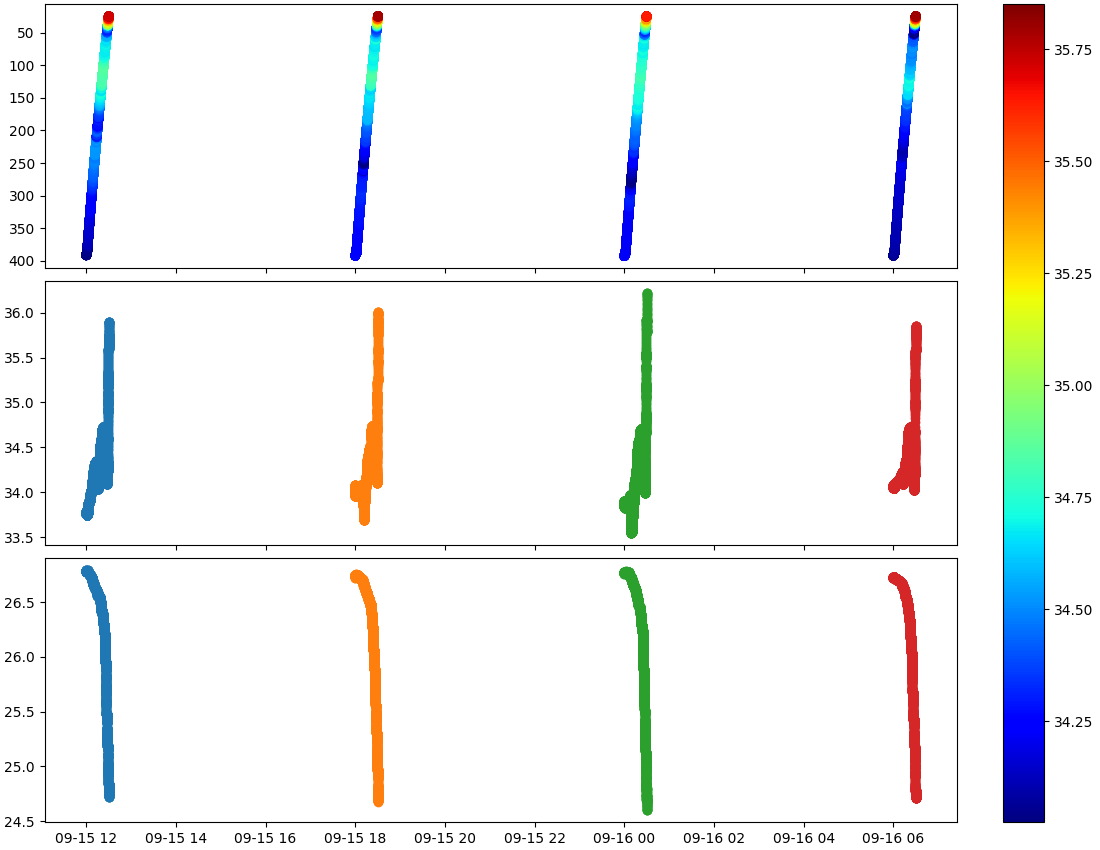

In [35]:
%matplotlib widget
#colors = ['tab:blue','black','tab:green','tab:purple']

fig, ax = plt.subplots(3,1, figsize = (11,8.5), constrained_layout = True, sharex = True)

for i in range(len(profiles)):

    pro = profiles[i]

    pscat = ax[0].scatter(pro.time, pro.depth, c = pro.conductivity, cmap = 'jet')

    ax[1].scatter(pro.time, pro.conductivity)

    ax[2].scatter(pro.time, pro.potential_density)

ax[0].invert_yaxis()
fig.colorbar(pscat,ax = ax)
#
#     ax.plot(pro.sea_water_density, pro.depth, alpha = 0.8, label = pro.profile_id.values, linewidth = 2)
#
# ax.legend(loc = 'lower left')
#
# ax.set_ylim(0,400)
#
# ax.invert_yaxis()
# ax.set_ylabel('Depth (m)')
# ax.set_xlabel(r'Spiciness0')
